In [1]:
import yaml
import os
from test import *
from math import ceil
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from statistics import mean
from process_data import *
from utils import *

with open('../task_config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
project_dir = config["project_path"]  # Modify this to your need
base_dir = os.path.join(project_dir, config["postprocessed_dir"])
template_dir = os.path.join(project_dir, config["postprocessed_dir"], 'transformations/dlc3d')
individuals = config["individuals"]  # The objects that we will place a reference frame on
objs = config["objects"]
d = Task_data(base_dir, template_dir, individuals, objs)
n_dims = len(d.dims)
with open(os.path.join(base_dir, 'processed', 'gripper_trajs_in_obj_aligned_type1d_filtered.pickle',), 'rb') as f1:
    gripper_trajs_in_obj = pickle.load(f1)
with open(os.path.join(base_dir, 'processed', 'HTs_obj_in_ndi.pickle',), 'rb') as f2:
    HTs_obj_in_ndi = pickle.load(f2)
    
ind = -1
d.gripper_trajs_truncated = d.get_gripper_trajectories_for_each_action()
gripper_traj_in_ndi = d.gripper_trajs_truncated[ind]
gripper_traj_in_obj = gripper_trajs_in_obj[ind]

demos = gripper_traj_in_ndi.keys()
bad_demos = ['506373', '781806', '506365', '648027', '740521']
demos = [demo for demo in demos if demo not in bad_demos]
test_demos = demos[0:2] 
train_demos = [d for d in demos if d not in test_demos]

example_demo = demos[0]
object_pos = []
for obj_demos in gripper_trajs_in_obj[0].keys(): 
    for d in gripper_trajs_in_obj[0][obj_demos].keys():
        if d==example_demo:
            df = gripper_trajs_in_obj[0][obj_demos][d]
            object_pos.append(df[['x','y','z']].iloc[0].tolist())
object_pos = np.array(object_pos)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
example_demo

'506366'

In [3]:
from itertools import combinations 
%matplotlib notebook
        
for comb in combinations(range(5), 2):
    print(f"point pair: {comb}]")
    test_pts = pairwise_constrained_axis3d(object_pos[comb[0],:], object_pos[comb[1],:], 0)
#     for comb in combinations(range(3), 2):
#         print(f"Test perpendicular between axis{comb}: {round(np.dot(test_pts[comb[0]], test_pts[comb[1]]), 3)}")

    # apply transform
    vec_transform = axis3d_to_quat(test_pts)
    std_axis3d = np.diag([1.0,1.0,1.0])
    vec_list = []
    for k, i in enumerate(test_pts):
        new_vec = vec_transform.apply(i)
        vec_list.append(new_vec)
#         print(np.round(new_vec, 3))
#         print((np.round(i,3)==np.round(vec_transform.inv().apply(std_axis3d[k]), 3)).all(), np.round(i,2),np.round(vec_transform.inv().apply(std_axis3d[k]), 2))
#     for comb in combinations(range(3), 2):
#         print(np.dot(vec_list[comb[0]], vec_list[comb[1]]) > 0.0000001)

point pair: (0, 1)]
point pair: (0, 2)]
point pair: (0, 3)]
point pair: (0, 4)]
point pair: (1, 2)]
point pair: (1, 3)]
point pair: (1, 4)]
point pair: (2, 3)]
point pair: (2, 4)]
point pair: (3, 4)]


<IPython.core.display.Javascript object>


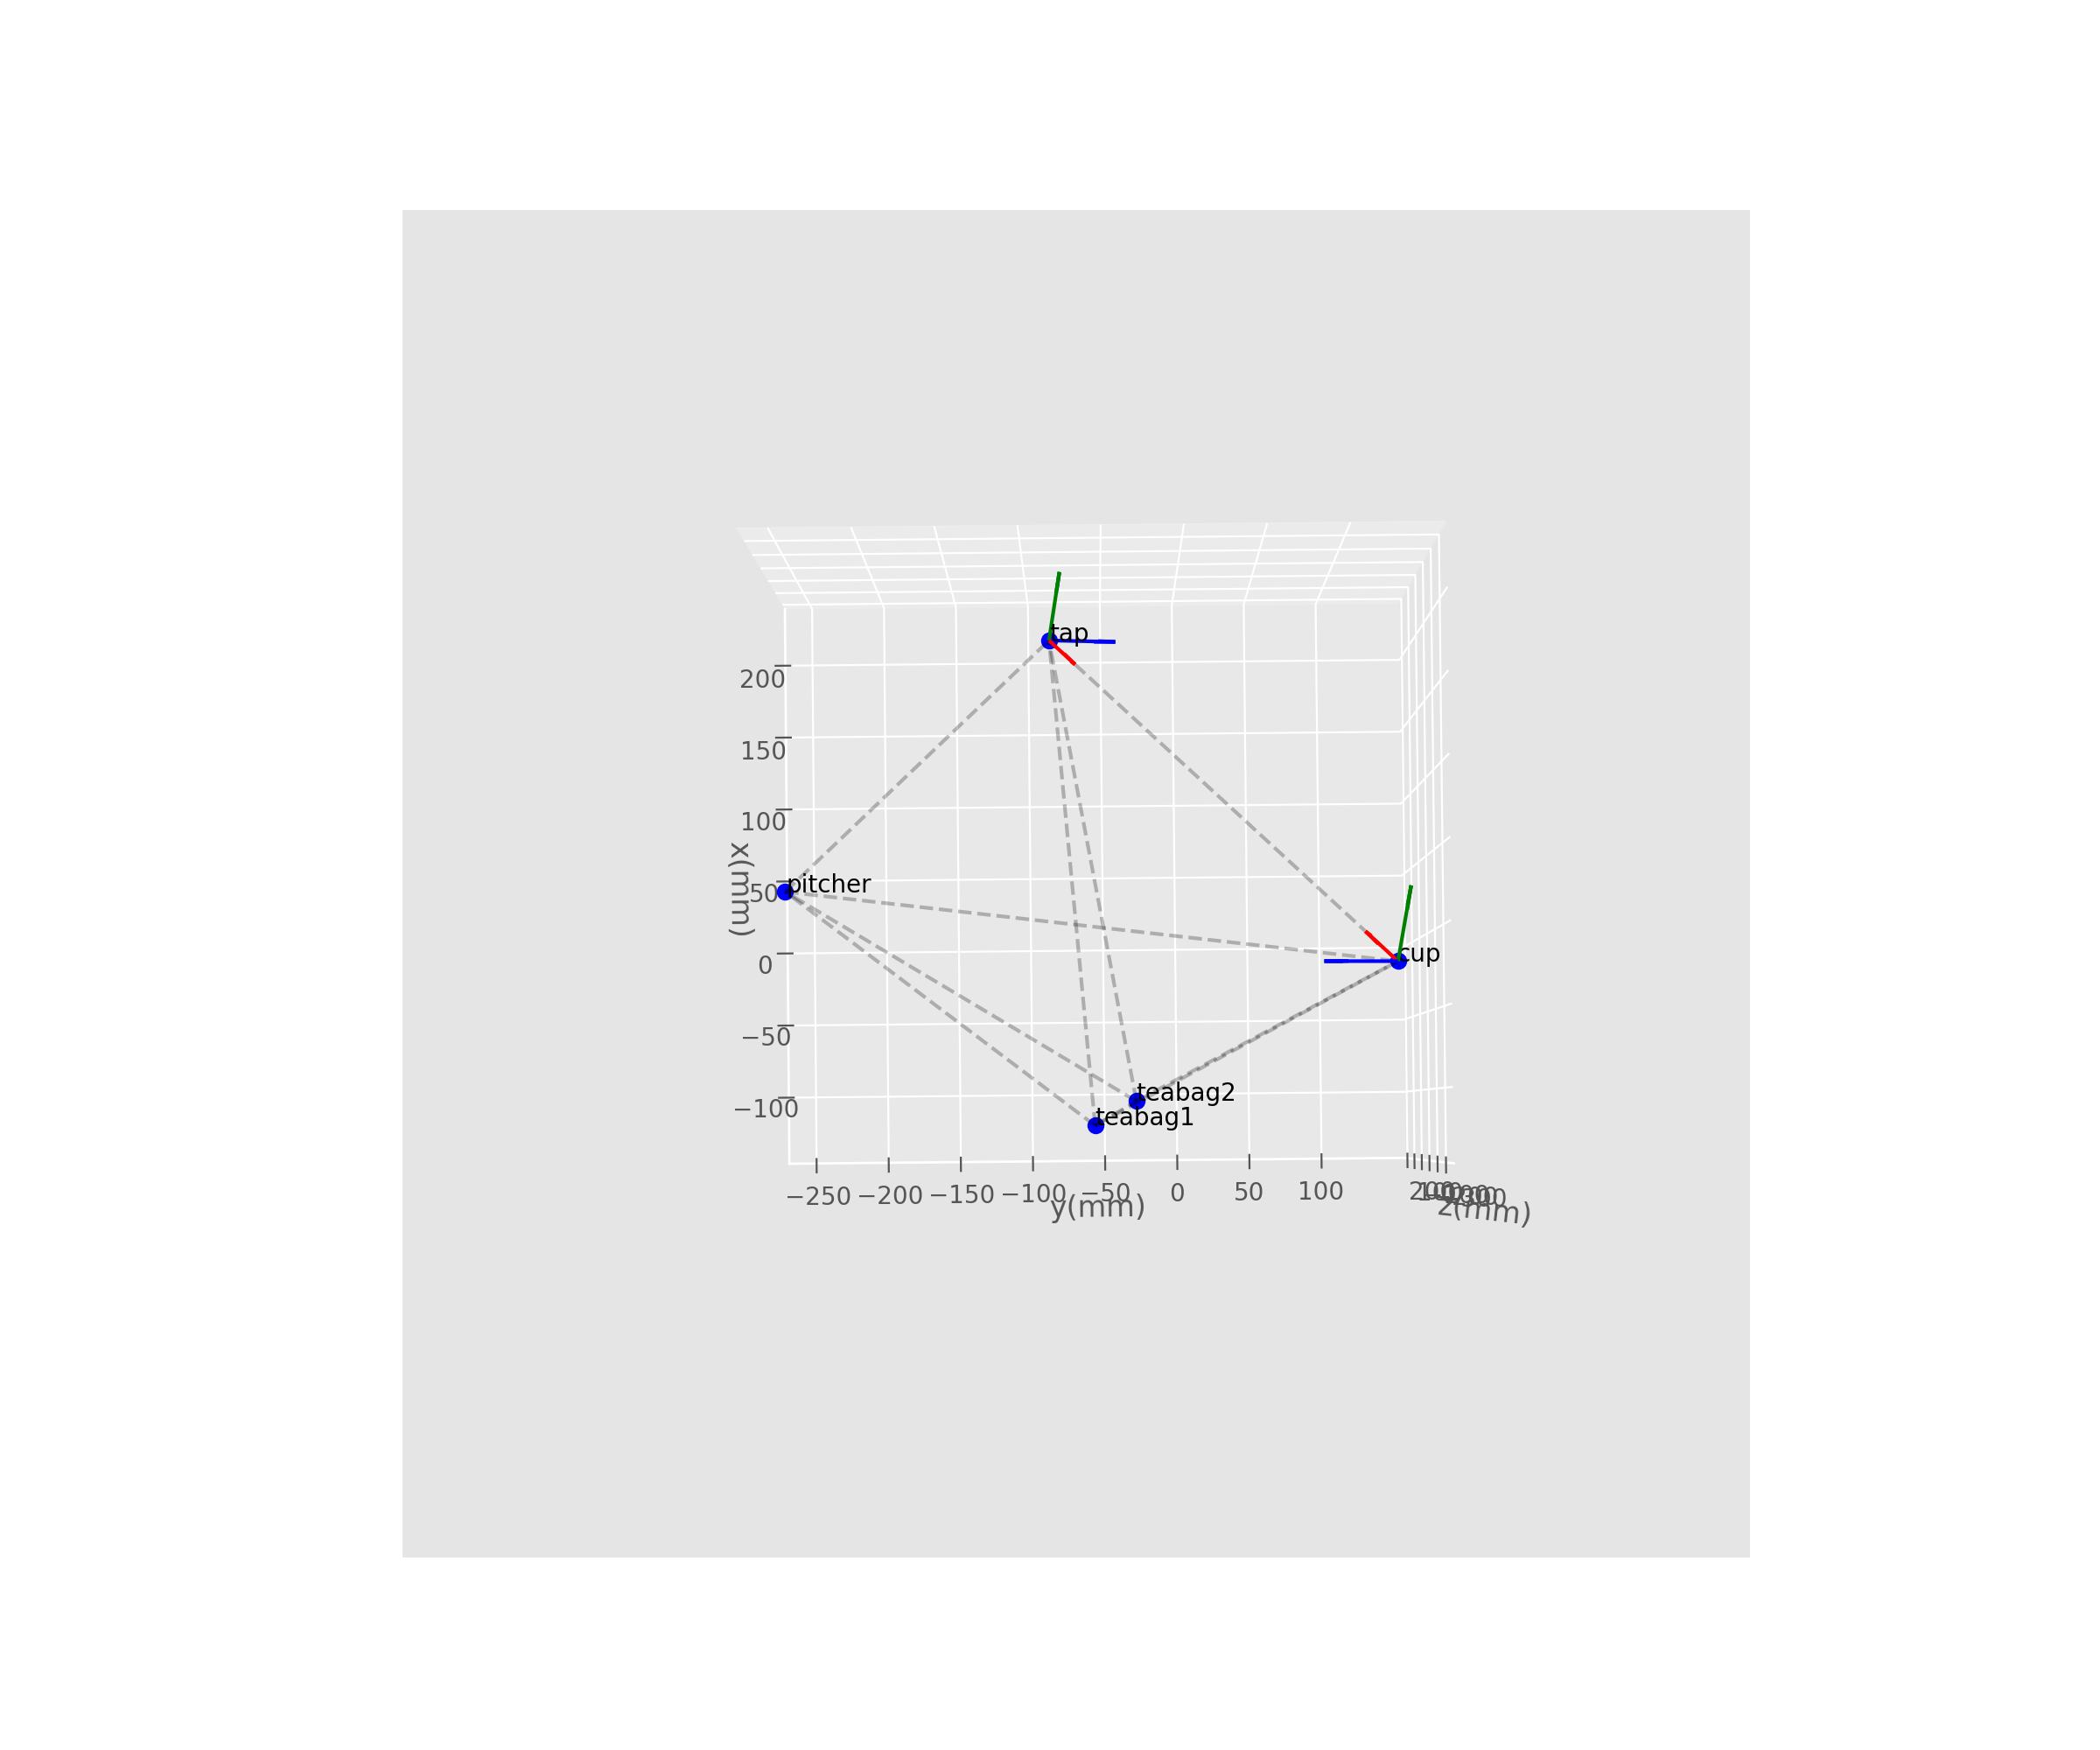

In [4]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

theta = np.linspace(0, 2 * np.pi, 201)
y = np.cos(theta)
z = np.sin(theta)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('x(mm)')
ax.set_ylabel('y(mm)')
ax.set_zlabel('z(mm)')
ax.set_box_aspect((np.ptp(object_pos[:,0]), np.ptp(object_pos[:,1]), np.ptp(object_pos[:,2])))
obj_list = list(gripper_trajs_in_obj[0].keys())

for k, pos in enumerate(object_pos):
    ax.plot(pos[0], pos[1], pos[2], 'o', color='blue')
    ax.text(pos[0], pos[1], pos[2]+10, obj_list[k], color='black')

axis_colors = ['red', 'blue', 'green']
for comb in combinations(range(5), 2):
    ax.plot(object_pos[comb,0], object_pos[comb,1], object_pos[comb,2], "--",color='black', alpha=.25)
    if comb==(3,4):
        axis_obj0 = pairwise_constrained_axis3d(object_pos[comb[0]], object_pos[comb[1]], up_axis=0)
        axis_obj1 = pairwise_constrained_axis3d(object_pos[comb[1]], object_pos[comb[0]], up_axis=0)
        for dim in range(3):
            ax.quiver(*object_pos[comb[0]], *axis_obj0[dim], length=50, color=axis_colors[dim])
            ax.quiver(*object_pos[comb[1]], *axis_obj1[dim], length=50, color=axis_colors[dim])

                

In [5]:
gripper_trajs_in_obj[0].keys()

dict_keys(['teabag1', 'teabag2', 'pitcher', 'cup', 'tap'])